# Домашняя работа 6. Факторный анализ

Вариант с кредитами.

Лазарев Эдуард Артемович
N33471

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

In [2]:
# Загружаем данные
df = pd.read_csv("default of credit card clients.csv", decimal=",", delimiter=";")
len(df)

30000

Проверяем правильность данных

In [3]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [4]:
df.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default_payment_next_month    int64
dtype: object

Разделим предиткоры и отклик.

In [5]:
from sklearn import preprocessing

X = df.iloc[:, :-1].values
X = pd.DataFrame((preprocessing.StandardScaler().fit_transform(X)).astype('float64'))
Y = df.iloc[:, -1].values

Выделим 70% выборки (X_train, Y_train) под обучение и 30% под тестовую выборку (X_test, Y_test).

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3,random_state=7787)

Подбираем основные и самые главные параметры при помощи GridSearch

In [7]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

grid_param = {  
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 4, 6]
}

model = XGBClassifier(random_state=17)
xgb_res = GridSearchCV(error_score='raise',
                        estimator=model, param_grid=grid_param, cv=5, 
                               pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

xgb_res.fit(X_train, Y_train)

xgb_res.best_params_, xgb_res.best_score_

({'max_depth': 3, 'n_estimators': 100}, 0.8215238095238094)

Оценим работу модели


In [8]:
from sklearn.metrics import accuracy_score

print("Accuracy on train set is ", accuracy_score(Y_train, xgb_res.predict(X_train)))
print("Accuracy on test set is ", accuracy_score(Y_test, xgb_res.predict(X_test)))

Accuracy on train set is  0.8253809523809523
Accuracy on test set is  0.8206666666666667


Посмотрим, нужна ли калибровка.

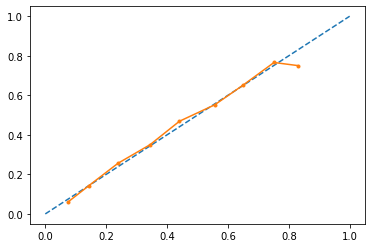

In [9]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
probs = xgb_res.predict_proba(X_test)[:,1]
fop, mpv = calibration_curve(Y_test, probs, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

По результатам - калибровка не нужна

In [10]:
!pip install factor_analyzer

     |████████████████████████████████| 40kB 2.8MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp37-none-any.whl size=40398 sha256=76c77817e2a6bd1335c811a84bbf78bb036e3907720c7700184e92aeb3e36e05
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


In [11]:
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA

 Посмотрим на собственные числа, чтобы определить число главных компонент. Будем сравнивать их с 1 (критерий Кайзера)

In [12]:
pca = PCA(n_components=16)
zzz = pca.fit(X)
print((pca.explained_variance_ratio_ * X.shape[1]).round(2))

[6.54 4.1  1.55 1.47 1.05 0.99 0.95 0.91 0.89 0.87 0.78 0.73 0.68 0.57
 0.52 0.4 ]


Надо оставить 5 факторов

In [13]:
fa = FactorAnalyzer( n_factors = 5, rotation='varimax',  method = 'minres', 
                    impute = 'mean',  is_corr_matrix=  False)

In [14]:
fa.fit(X)

FactorAnalyzer(bounds=(0.005, 1), impute='mean', is_corr_matrix=False,
               method='minres', n_factors=5, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

Смотрим распределение факторов

In [15]:
dfff = pd.DataFrame(X)
faLoadingsV = pd.DataFrame(np.vstack((fa.loadings_.T, fa.get_uniquenesses())),
                          index = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5', 'Уникальность'], 
                           columns = list(df.iloc[:, :-1].columns.values))
faLoadingsV.round(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
Factor 1,0.021,0.268,-0.010,-0.003,-0.005,0.017,0.135,0.144,0.132,0.134,0.143,0.159,0.915,0.931,0.900,0.905,0.884,0.851,0.115,0.067,0.102,0.105,0.121,0.101
Factor 2,-0.021,-0.353,-0.075,0.144,0.026,-0.039,0.656,0.839,0.844,0.853,0.853,0.771,0.112,0.134,0.151,0.157,0.164,0.165,-0.014,-0.010,-0.028,-0.036,-0.044,-0.035
Factor 3,0.020,0.393,-0.009,-0.117,-0.013,0.046,-0.144,-0.097,-0.065,-0.049,-0.029,-0.015,0.133,0.174,0.264,0.279,0.299,0.307,0.479,0.489,0.474,0.400,0.345,0.345
Factor 4,0.039,0.109,-0.053,0.235,-0.529,0.794,-0.010,-0.013,-0.024,-0.024,-0.034,-0.036,0.053,0.047,0.043,0.037,0.033,0.029,0.004,0.003,0.006,0.006,0.004,0.008
Factor 5,0.004,0.037,0.031,-0.037,-0.009,0.015,-0.199,-0.322,-0.091,0.162,0.383,0.318,-0.081,-0.065,-0.016,0.061,0.081,0.061,0.017,0.031,0.051,0.003,-0.039,-0.038
Уникальность,0.997,0.635,0.990,0.909,0.720,0.365,0.491,0.162,0.258,0.225,0.104,0.278,0.123,0.079,0.095,0.072,0.095,0.150,0.757,0.755,0.762,0.828,0.863,0.868


In [16]:
factors_2 = pd.DataFrame(fa.transform(X), columns = ['F1', 'F2','F3', 'F4','F5'])
factors_2

,F1,F2,F3,F4,F5
0,-0.510623,-0.049181,-0.606179,-0.561856,-3.103295
1,-0.723534,0.909204,-0.191775,-0.906336,-0.665232
2,-0.425374,0.231591,-0.334857,-0.318916,0.150333
3,-0.069733,0.215902,-0.414243,0.342635,0.070593
4,-0.644775,0.197679,0.312826,1.796241,0.411046
...,...,...,...,...,...
29995,1.218738,0.060464,-0.202413,0.723477,-0.654046
29996,-0.611871,-0.322310,-0.167284,0.473153,1.053644
29997,-0.752185,1.550850,-0.063516,-0.010242,-2.409036
29998,-0.443790,0.191108,1.435135,0.723778,0.229472


Собираем предыдущие предикторы и факторы для работы с новой моделью

In [17]:
X = pd.DataFrame(X)
df_full = X.merge(factors_2, left_index=True, right_index=True)
df_full

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,F1,F2,F3,F4,F5
0,-1.731993,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,-0.510623,-0.049181,-0.606179,-0.561856,-3.103295
1,-1.731878,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,-0.723534,0.909204,-0.191775,-0.906336,-0.665232
2,-1.731762,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,-0.425374,0.231591,-0.334857,-0.318916,0.150333
3,-1.731647,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,-0.069733,0.215902,-0.414243,0.342635,0.070593
4,-1.731531,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,-0.644775,0.197679,0.312826,1.796241,0.411046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.731531,0.404759,-1.234323,1.451114,-1.057295,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.870379,2.018136,2.326690,0.695474,-0.149259,-0.384392,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130,1.218738,0.060464,-0.202413,0.723477,-0.654046
29996,1.731647,-0.134759,-1.234323,1.451114,0.858557,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,-0.672786,-0.665299,-0.627430,-0.532924,-0.577691,-0.652724,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382,-0.611871,-0.322310,-0.167284,0.473153,1.053644
29997,1.731762,-1.059646,-1.234323,0.185828,0.858557,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,-0.647227,-0.643830,-0.638158,-0.347961,-0.324517,-0.327687,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001,-0.752185,1.550850,-0.063516,-0.010242,-2.409036
29998,1.731878,-0.674276,-1.234323,1.451114,-1.057295,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,-0.717982,0.410269,0.422373,0.147844,-0.468063,0.169130,4.844316,-0.109033,-0.229895,-0.185120,3.152536,-0.191904,-0.443790,0.191108,1.435135,0.723778,0.229472


Проверка улучшения модели

Модель для нового датасета с факторами

In [18]:
X1 = pd.DataFrame((preprocessing.StandardScaler().fit_transform(df_full)).astype('float64'))
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y, test_size=0.3,random_state=7787)

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_res1 = GridSearchCV(error_score='raise',
                        estimator=model, param_grid=grid_param, cv=2, 
                               pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

xgb_res1.fit(X_train1, Y_train1)

xgb_res1.best_params_, xgb_res1.best_score_

({'max_depth': 4, 'n_estimators': 100}, 0.8206190476190476)

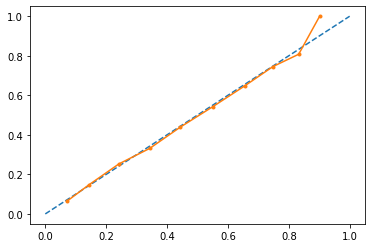

In [20]:
probs = xgb_res1.predict_proba(X_test1)[:,1]
fop, mpv = calibration_curve(Y_test1, probs, n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [21]:
print('Befor factor ', accuracy_score(Y_test, xgb_res.predict(X_test)))
print('After factor ', accuracy_score(Y_test1, xgb_res1.predict(X_test1)))

Befor factor  0.8206666666666667
After factor  0.8206666666666667


## Вывод

По результатам работы была построена модель для определения тех людей, которые выплатят кредит. А так же был произведён факторный анализ